In [1]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image
import copy
from tqdm import tqdm
import nevergrad as ng
import lpips

In [2]:
print(torch.__version__)

2.0.0


# Choose variants here:

In [3]:
trained_model = False
arch = 'ResNet18'
num_images = 64
batch_size = 1

## System setup:

In [4]:
import inversefed
setup = inversefed.utils.system_startup(gpu=4)
defs = inversefed.training_strategy('conservative')

# loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('ImageNet', defs, data_path='/mnt/7T/Data/Natural/ImageNet/')
loss_fn, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR100', defs, data_path='/mnt/7T/Data/Natural/')

# model = torchvision.models.resnet18(pretrained=trained_model)
model, _ = inversefed.construct_model(arch, num_classes=100, num_channels=3)
model.to(**setup)
model.eval();

Currently evaluating -------------------------------:
Tuesday, 21. May 2024 02:19PM
CPUs: 32, GPUs: 8 on user-SYS-421GE-TNRT.
GPU : NVIDIA GeForce RTX 4090
Files already downloaded and verified
Files already downloaded and verified
Model initialized with random key 173732077.


In [5]:
# dm = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None]
# ds = torch.as_tensor([0.5, 0.5, 0.5], **setup)[:, None, None]

dm = torch.as_tensor(inversefed.consts.cifar100_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.cifar100_std, **setup)[:, None, None]


def grid_plot(tensor, labels):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if num_images == 1:
        fig, axes = plt.subplots(1, 1, figsize=(4, 4))
    elif num_images == 64:
        fig, axes = plt.subplots(num_images // 8, 8, figsize=(12, num_images // 16 * 3))
    else:
        fig, axes = plt.subplots(25, 25, figsize=(12, 12))
    axes = np.reshape(axes, -1)
    for im, l, ax in zip(tensor, labels, axes):
        ax.imshow(im.permute(1, 2, 0).cpu())
#         ax.set_title(l)
        ax.axis('off')
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
#     plt.savefig('out/cifar100.pdf')

## BigGAN model

In [6]:
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal, convert_to_images)

In [7]:
# Load pre-trained model tokenizer (vocabulary)
generator= BigGAN.from_pretrained('biggan-deep-256').to(setup['device'])

# Reconstruct

### Build the input (ground-truth) gradient

In [8]:
idx = 48

ground_truth_all, labels_all = [], []
while len(labels_all) < num_images:
    img, label = validloader.dataset[idx]
    idx += 1
    # skip the images with same labels when images <= num_classes
    if label not in labels_all or len(labels_all) >= 100:
        labels_all.append(torch.as_tensor((label,), device=setup['device']))
        ground_truth_all.append(img.to(**setup))

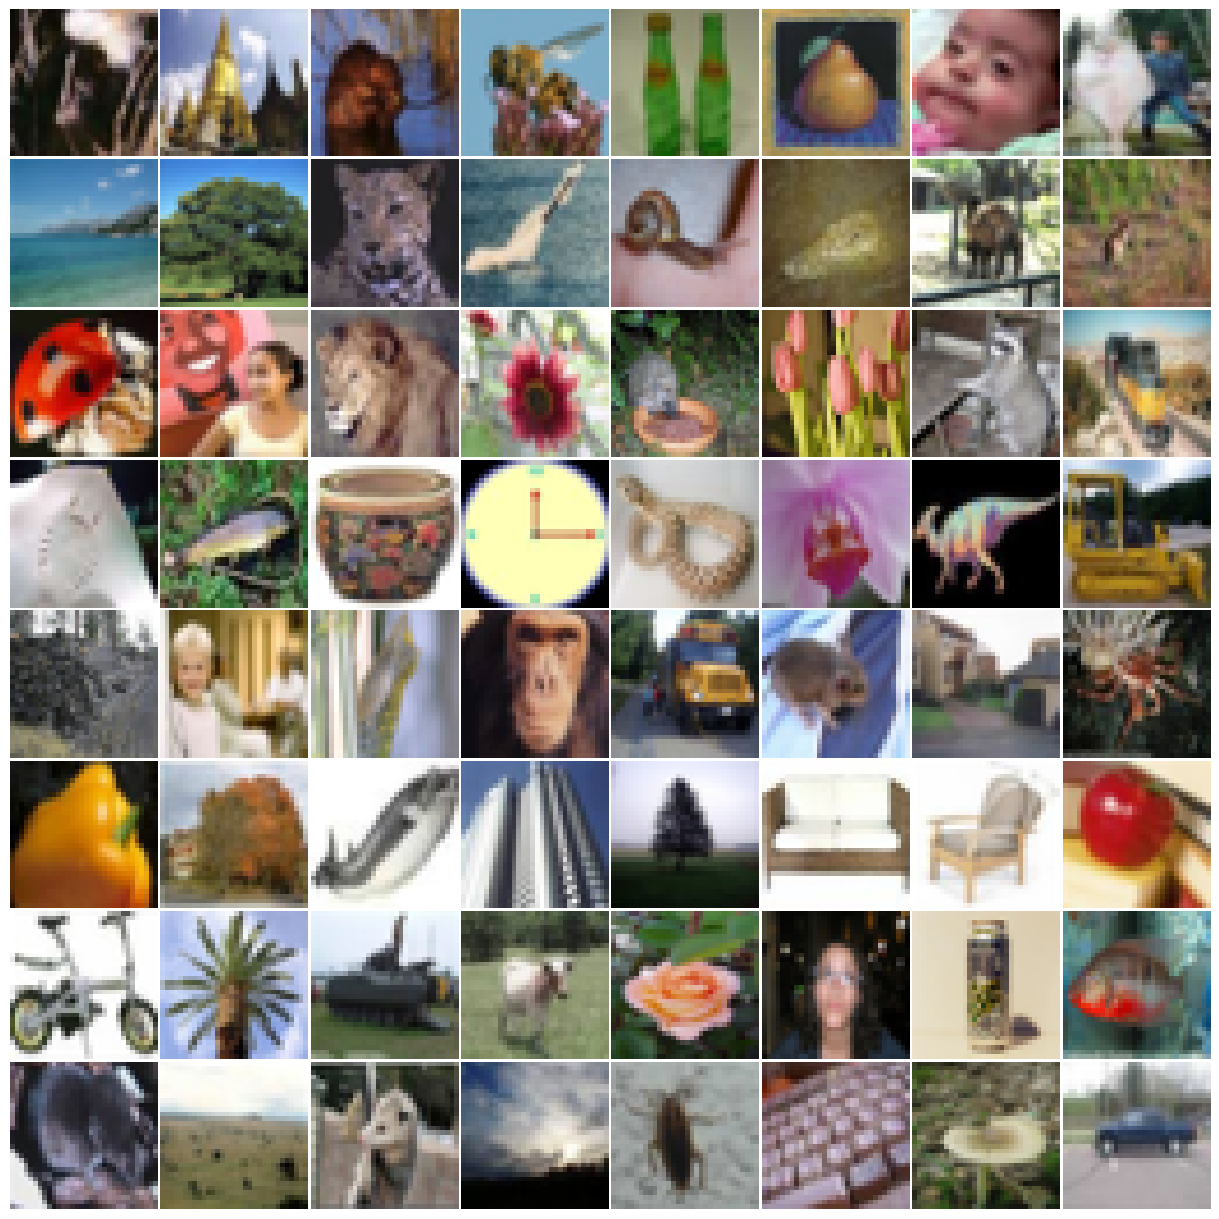

In [9]:
grid_plot(torch.stack(ground_truth_all), labels_all);

In [10]:
import random
import nevergrad as ng
from reconstructor import NGReconstructor

In [11]:
# divide into batches
list_all = list(range(num_images))
# random.shuffle(list_all)
list_all = [list_all[i:i + batch_size] for i in range(0, len(list_all), batch_size)]
# print(list_all)
x_res_all = []
for lists in list_all:
    ground_truth = torch.stack([ground_truth_all[i] for i in lists])
    labels = torch.cat([labels_all[i] for i in lists])
#     print(labels)
    
    model.zero_grad()
    target_loss, _, _ = loss_fn(model(ground_truth), labels)
    input_gradient = torch.autograd.grad(target_loss, model.parameters())
    input_gradient = [grad.detach() for grad in input_gradient]
    full_norm = torch.stack([g.norm() for g in input_gradient]).mean()
#     print(f'Full gradient norm is {full_norm:e}.')
    
    ng_rec = NGReconstructor(fl_model=model, generator=generator, loss_fn=loss_fn,
                                     num_classes=1000, search_dim=(128, batch_size), strategy='CMA', budget=1, use_tanh=True, defense_setting=None)

    z_res, x_res, img_res, loss_res = ng_rec.reconstruct(input_gradient, labels)
    
    x_res_all.append(torch.stack(x_res).squeeze(1))

x_res_all = torch.cat(x_res_all, dim=0)

Loss 5.6782: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


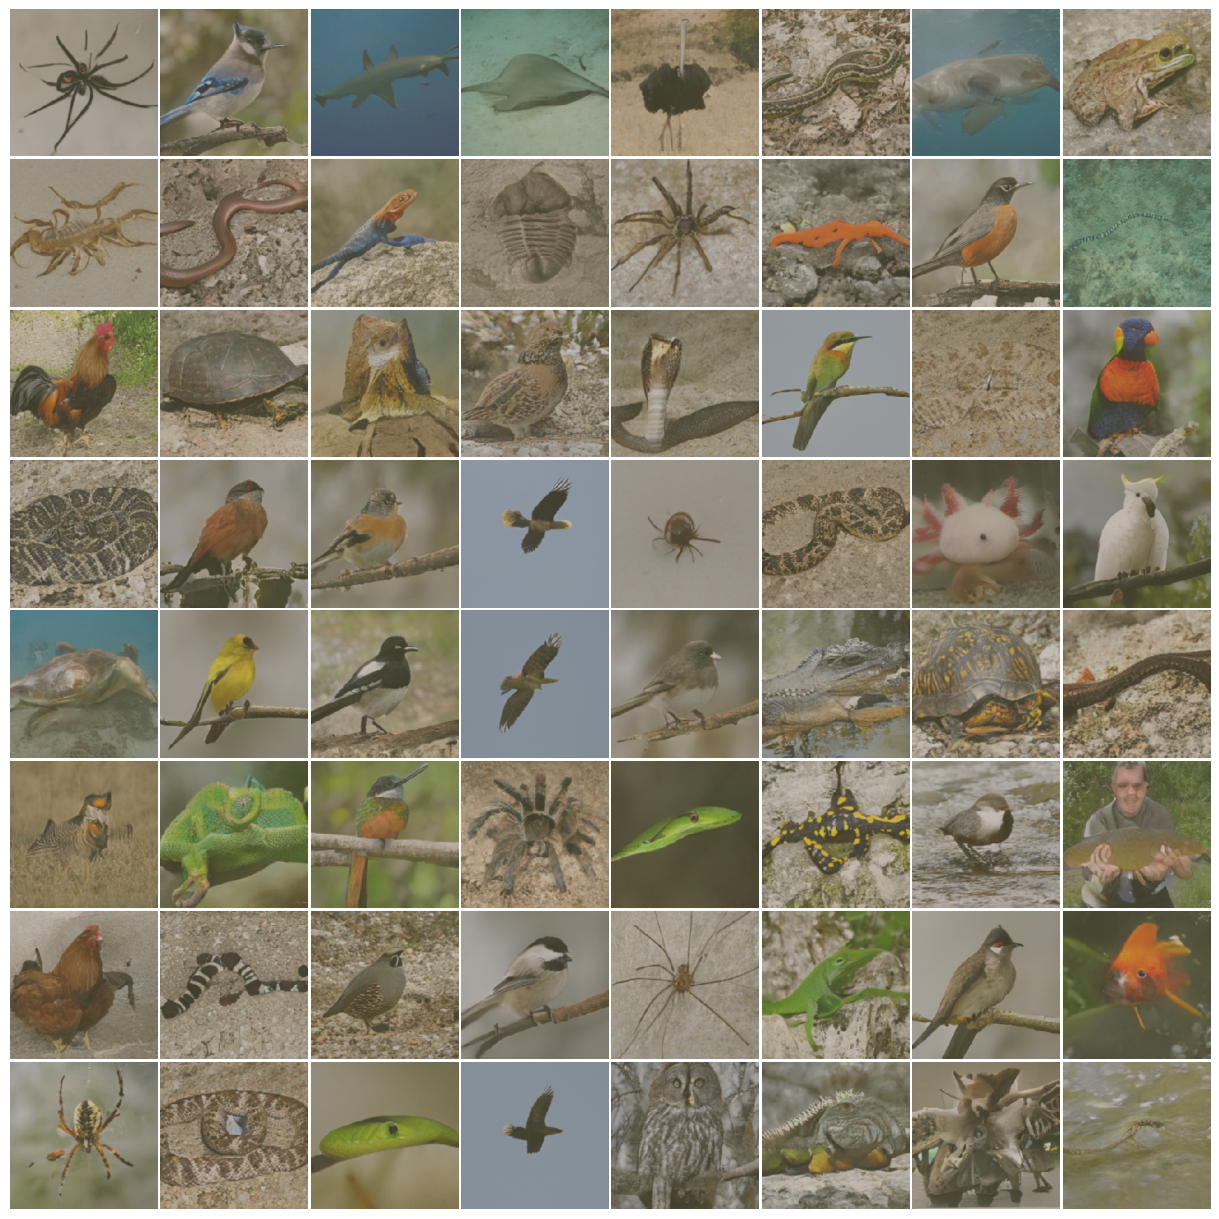

In [12]:
grid_plot(x_res_all, labels_all)

In [13]:
# import lpips

# # output = torch.stack(x_res).squeeze()
# ground_truth_all = torch.stack(ground_truth_all)

# test_psnr = inversefed.metrics.psnr(x_res_all, ground_truth_all, factor=1/ds)
# test_ssim = inversefed.metrics.cw_ssim(x_res_all, ground_truth_all, scales=5)
# lpips_scorer = lpips.LPIPS(net="alex").to(**setup)
# lpips_score = lpips_scorer(x_res_all, ground_truth_all, normalize=True)
# avg_lpips = lpips_score.mean().item()
# # print(f"Rec. loss: {stats['opt']:2.4f} | MSE: {test_mse:2.4f} "
# #       f"| PSNR: {test_psnr:4.2f} | FMSE: {feat_mse:2.4e} |");
# print(f"Rec. | PSNR: {test_psnr:4.2f} | SSIM: {test_ssim:2.4f} | LPIPS: {avg_lpips:2.4f}")